In [5]:
import matplotlib
%matplotlib inline

# core libs
import os
import itertools
from collections import defaultdict, OrderedDict
import json
import yaml
import codecs
import re
import cPickle as pickle

from functools import wraps
from unidecode import unidecode

# numerical and ml libs
import numpy as np
from scipy.sparse import coo_matrix, hstack
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import spacy
from spacy.strings import StringStore
import sklearn
print("using sklearn version -> %s" % sklearn.__version__)
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import linear_model, datasets, svm, ensemble
from sklearn.utils.extmath import safe_sparse_dot
import matplotlib.pyplot as plt

# project files
from dfiner.ontonote.ontonotes_data import load_ontonotes, read_figer, GoldMentionView
from dfiner.utils import get_default_config, get_size, dump_pickle, load_pickle
from dfiner.datastructures.utils import print_view
from dfiner.annotators.hyp_pattern_annotator import HypPatternAnnotator
from dfiner.annotators.kb_bias_annotator import KBBiasTypeAnnotator
from dfiner.annotators.nsd_annotator import NSDView
from dfiner.annotators.fine_type_annotator import FineTypeView
from dfiner.annotators import get_non_default_annotator
import dfiner.ontonotes_annotation_extender as oae
from dfiner.topics import get_embedding_func, EmbeddingsType
from dfiner.classifier.lexicon import Lexicon
from dfiner.classifier.feature_function import DenseFeatureFunction, FeatureExtractor, FeatureFunction

config = get_default_config()

using sklearn version -> 0.18.1


In [2]:
%%time
nlp = spacy.load('en')

CPU times: user 4.99 s, sys: 456 ms, total: 5.44 s
Wall time: 5.45 s


In [3]:
%%time
train_docs = load_ontonotes(nlp, config['ontonotes_train_and_dev_path'])
test_docs = load_ontonotes(nlp, config['ontonotes_test_path'])
figer_docs = read_figer(nlp, config['figer_path'])

CPU times: user 2min 15s, sys: 424 ms, total: 2min 15s
Wall time: 2min 15s


In [6]:
figer_gold_path = config["figer_gold"]
figer_gold_docs = read_figer(nlp, figer_gold_path)

In [7]:
def annotate_extend(docs):
    _ = [oae.add_titles(doc, oae.title_set) for doc in docs]
    _ = [oae.add_typexs('MEDICINE', doc, oae.symptom_alias_set.union(oae.drug_set.union(oae.treatment_set))) for doc in docs]
    _ = [oae.add_typexs('ANIMAL', doc, oae.animal_set) for doc in docs]
    _ = [oae.add_typexs('ROAD', doc, oae.road_set) for doc in docs]

In [8]:
%%time
annotate_extend(train_docs)
annotate_extend(test_docs)

CPU times: user 54.8 s, sys: 256 ms, total: 55.1 s
Wall time: 54.7 s


In [9]:
print "loaded %d train docs" % len(train_docs)
print "loaded %d test docs" % len(test_docs)
print "loaded %d figer docs" % len(figer_docs)

loaded 83533 train docs
loaded 9518 test docs
loaded 434 figer docs


In [10]:
kba = KBBiasTypeAnnotator(config)

In [11]:
hyp_pattern_annotator = HypPatternAnnotator(nlp)

In [12]:
with open(config["ontonote_to_figer_map"]) as f_in:
    ontonotes_to_figer_course = yaml.load(f_in)

def type_func(mention_constituent):
    return ontonotes_to_figer_course[mention_constituent.name]

def get_figer_type_func(kba):
    def figer_type_func(mention_constituent):
        all_types = mention_constituent.name.split(",")
        course_types = set(kba.type_system.get_root, all_types)
    

In [13]:
def slash_to_dot(slash_str):
    return ".".join(slash_str.split("/")[1:])

def get_figer_type_func(kba):
    def figer_type_func(mention_constituent):
        all_types = map(slash_to_dot, mention_constituent.name.split(","))
        try:
            course_types = list(set(map(kba.type_system.get_root, all_types)))
            if len(course_types) > 1:
                print "CAUTION: more than one course types -> (%s). Assigining (%s)." % (course_types, course_types[0])
                return course_types[0]
            return course_types[0]
        except:
            print "CAUTION: encoutered error while looking up (%s)" % (all_types)
            return None
    return figer_type_func

figer_type_func = get_figer_type_func(kba)

In [21]:
%%time

VOCAB = set()

num_mentions = 0
for docs in [train_docs, test_docs, figer_docs]:
    for doc in docs:
        num_mentions += len(doc.user_data[GoldMentionView.GOLD_MENTION_VIEW_NAME])
        for token in doc:
            VOCAB.add(token.text)

print("%d mention loaded" % num_mentions)
print("%d word loaded" % len(VOCAB))


def loadW2V(w2v_file, allowed = None):
    ret = {}
    err = 0
    with codecs.open(w2v_file, "r" , 'utf-8') as f_in:
        for line in f_in:
            line = line.strip()
            if len(line) == 0:
                continue
            try:
                w, vec = line.split("\t")
            except ValueError:
#                 print(line)
                err += 1
                continue
            if allowed is not None and w in allowed:
                vec = [float(v) for v in vec.split(" ")]
                ret[w] = np.array(vec)
    print("%d line failed" % err)
    return ret


w2vdict_file_path = "/tmp/w2vdict.pkl"
try:
    with open(w2vdict_file_path) as f_in:
        w2vdict = pickle.load(f_in)
except:
    print "couldn't load w2v from cache"
    w2vdict = None

# w2vdict = None
if w2vdict is None:
    w2vdict=loadW2V(config["embeddings_path"], VOCAB)
    try:
        with open(w2vdict_file_path, 'w') as f_out:
            pickle.dump(w2vdict, f_out, pickle.HIGHEST_PROTOCOL)
    except:
        print "couldn't cache w2v"

print("%d words have w2v" % len(w2vdict))

default_w2v_mean = np.mean(list(w2vdict.values()), axis=0)
default_w2v_zero = np.zeros(default_w2v_mean.shape)

167240 mention loaded
57541 word loaded
45428 words have w2v
CPU times: user 1.13 s, sys: 52 ms, total: 1.18 s
Wall time: 1.18 s


In [22]:
from spacy.strings import hash_string

In [23]:
print len(set([(doc.text) for doc in train_docs]))

77553


In [24]:
%%time
print "number of train docs - " + str(len(train_docs))
print len(set([hash_string(doc.text) for doc in train_docs]))

number of train docs - 83533
77553
CPU times: user 580 ms, sys: 12 ms, total: 592 ms
Wall time: 535 ms


In [25]:
# lsi_embedding_func = get_embedding_func(config, EmbeddingsType.LSI, 100)
# lda_embedding_func = get_embedding_func(config, EmbeddingsType.LDA, 50)

In [26]:
# Define features:

# from nltk.stem.wordnet import WordNetLemmatizer
# lmtzr = WordNetLemmatizer().lemmatize


def word_shape_func(text):
    text = re.sub("[a-z]+", "a" ,text)
    text = re.sub("[A-Z]+", "A" ,text)
    text = re.sub("[0-9]+", "0" ,text)
    return text

    


@FeatureFunction("dep_feature")
def mention_details(doc, mention):
    start, end = mention.start, mention.end
    heads = [token.head for token in doc[start:end]]
    deps = [list(token.children) for token in doc[start:end]]
    for token, head, children in zip(doc[start:end], heads, deps):
        if not (head.i >= start and head.i < end):            
            yield "<-%s- %s" % (token.dep_, head.lemma_)
            yield "<- %s" % (head.lemma_)
        for child in children:
            if not (child.i >= start and child.i < end):
                yield  "-%s-> %s" % (child.dep_,child.lemma_)
                yield  "-> %s" % (child.lemma_)


def word_before(pos):
    @FeatureFunction("word_before")
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(max(start-pos,0), start):
            yield doc[i].text
#             yield word_shape_func(doc[i].text)
    return f


def word_before_loc(pos):
    @FeatureFunction("word_before")
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(max(start-pos,0), start):
            yield "%d-%s" % (start - i,doc[i].text)
    return f


def word_before_lemma(pos):
    @FeatureFunction("word_before_lemma")
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(max(start-pos,0), start):
            yield doc[i].lemma_
    return f


def word_after(pos):
    @FeatureFunction("word_after")
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(end, min(end+pos,len(doc))):
            yield doc[i].text
#             yield word_shape_func(doc[i].text)
    return f


def word_after_loc(pos):
    @FeatureFunction("word_after_loc")
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(end, min(end+pos,len(doc))):
            yield "%d-%s" % (i - end,doc[i].text)
    return f


def word_after_lemma(pos):
    @FeatureFunction("word_after_lemma")
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(end, min(end+pos,len(doc))):
            yield doc[i].lemma_
        
    return f


@FeatureFunction("wim")
def word_in_mention(doc, mention):
    start, end = mention.start, mention.end
    for token in doc[start:end]:
        yield token.text
        yield word_shape_func(token.text)

@FeatureFunction("wim_lemma")
def word_in_mention_lemma(doc, mention):
    start, end = mention.start, mention.end
    for token in doc[start:end]:
        yield token.lemma_
        

@FeatureFunction("wim_loc")
def word_in_mention_loc(doc, mention):
    start, end = mention.start, mention.end
    for i,x in enumerate(doc[start:end]):
        yield "f%d-%s" % (i,x.text)
        yield "b%d-%s" % ((end-start-1) - i,x.text)
        

@FeatureFunction("wim_loc_lemma")
def word_in_mention_loc_lemma(doc, mention):
    start, end = mention.start, mention.end
    for i,x in enumerate(doc[start:end]):
        x = x.lemma_
        yield "f%d-%s" % (i,x)
        yield "b%d-%s" % ((end-start-1) - i,x)
    

def wim_ngram(n=2):
    @FeatureFunction("wim_%dgram" % n)
    def f(doc, mention):
        start, end = mention.start, mention.end
        words = map(lambda token: token.text, doc[start:end])
        for ngram_tup in zip(*[words[i:] for i in xrange(n)]):
            yield "-".join(ngram_tup)
    return f
        

def wim_ngram_lemma(n=2):
    @FeatureFunction("wim_%dgram_lemma" % n)
    def f(doc, mention):
        start, end = mention.start, mention.end
        words = map(lambda token: token.lemma_, doc[start:end])
        for ngram_tup in zip(*[words[i:] for i in xrange(n)]):
            yield "-".join(ngram_tup)
    return f
        

@FeatureFunction("word_shape")
def word_shape(doc, mention):
    start, end = mention.start, mention.end
    t = " ".join([x.text for x in doc[start:end]])
    return [word_shape_func(t)]
        

@FeatureFunction("length")
def mention_length(doc, mention):
    start, end = mention.start, mention.end
    return ["%d" % (end-start)]
        

@FeatureFunction("prefix")
def prefix(doc, mention):
    start, end = mention.start, mention.end
    for w in doc[start:end]:
        for i in range(3, min(5, len(w.text))):
            yield w.text[:i]
        

@FeatureFunction("suffix")
def postfix(doc, mention):
    start, end = mention.start, mention.end
    for w in doc[start:end]:
        for i in range(3, min(5, len(w.text))):
            yield w.text[-i:]

# KB-Bias features
def kbbias(kbbias_annotator):
    @FeatureFunction("kbbias")
    def wrappee(doc, mention):
        surface = doc[mention.start:mention.end].text
        results = None
        if surface in kbbias_annotator.surface_to_type_dist:
            results = kbbias_annotator.surface_to_type_dist[surface]
        elif (surface[:4].lower() == 'the ') and \
              surface[4:] in kbbias_annotator.surface_to_type_dist:
            results = kbbias_annotator.surface_to_type_dist[surface[4:]]
        if results:
            return results.iteritems()
        else:
            return []
    return wrappee
             


@FeatureFunction("bias")
def CONSTANT_BIAS(doc, mention):
    start, end = mention.start, mention.end
    return ["bias"]

# def gazzarteer(gas):
#     @FeatureFunction("gazzarteer")
#     def gazzarteer_wrappee(mention):
#         for gz_name in gas:
#             if mention.surface:
#                 return


def getOrDefault(m, k, d):
    if k in m:
        return m[k]
    else:
        return d


def w2vBefore(w2v_dict, default_w2v, pos = 4):  
    @DenseFeatureFunction()
    def w2vBefore(doc, mention):
        word_vecs = []
        for i in range(mention.start-pos, mention.start):
            if i < 0:
                word_vecs.append(np.zeros(default_w2v.shape))
            else:
                word_vecs.append(getOrDefault(w2v_dict, doc[i].text, default_w2v))
        word_vecs.append(np.mean(word_vecs, axis=0))
        return np.hstack(word_vecs)
    return w2vBefore


def w2vAfter(w2v_dict, default_w2v, pos = 4):    
    @DenseFeatureFunction()
    def w2vAfter(doc, mention):
        word_vecs = []
        for i in range(mention.end, mention.end+pos):
            if i >= len(mention.tokens):
                word_vecs.append(np.zeros(default_w2v.shape))
            else:
                word_vecs.append(getOrDefault(w2v_dict, doc[i].text, default_w2v))
        word_vecs.append(np.mean(word_vecs, axis=0))
        return np.hstack(word_vecs)
    return w2vAfter


def w2vMention(w2v_dict, default_w2v):    
    @DenseFeatureFunction(dim=300)
    def w2vMention(doc, mention):
        if mention.start == mention.end:
            print(doc)
        mean_vecs = [getOrDefault(w2v_dict, token.text, default_w2v) for token in doc[mention.start:mention.end]]
        return np.mean(mean_vecs, axis=0)
    return w2vMention


def topicSentence(sentEmbeddingFunc, feature_name):
    @DenseFeatureFunction()
    def topicSentence(doc, mention):
        tokenized_doc = [token.text for token in doc]
        return sentEmbeddingFunc(tokenized_doc)
    topicSentence.__name__ = feature_name
    return topicSentence

In [28]:
# features

# sparse feature functions

sparse_feat_funcs = [
#     CONSTANT_BIAS,
    mention_details,
    word_shape,
    word_in_mention, word_in_mention_lemma,
    word_in_mention_loc, word_in_mention_loc_lemma,
    wim_ngram(2), wim_ngram_lemma(2),
    wim_ngram(3), wim_ngram(3),
    kbbias(kba),
    w2vMention(w2vdict, default_w2v_mean)
                    ]
#             wim_ext, wim_ext_lemma,   
#             word_shape,
#             mention_length,
#             prefix,
#             postfix,
#             mention_pronoun_wh_dep
extractors = FeatureExtractor(sparse_feat_funcs)

In [42]:
def build_corpora(docs):
    ret = []
    for doc in docs:
        for m in doc.user_data["gold_mention_view"]:
            ret.append((doc, m))
    return ret

def build_ys_from_gold(docs, type_lex):
    ret = []
    missing = set()
    for doc, m in docs:
        type_lex.see_lexeme(m.name)
        idx = type_lex.getOrNegOne(m.name)
        if idx == -1:
            missing.add(m.name)
        ret.append(idx)
    for m in missing:
        print("missing lebel %s" % m)
    return np.array(ret)

type_lex = Lexicon()
    
ontonote_train = build_corpora(train_docs)
Y_train = build_ys_from_gold(ontonote_train, type_lex)

ontonote_test = build_corpora(test_docs)
Y_test = build_ys_from_gold(ontonote_test, type_lex)

figer_test = build_corpora(figer_docs)

In [39]:
force_update = False
extractors.build_lexicon(ontonote_train, force_update=force_update)
X_train = extractors.extract("ontonote-train", ontonote_train, force_update=force_update)
X_test = extractors.extract("ontonote-test", ontonote_test, force_update=force_update)
X_figer = extractors.extract("figer-train", figer_test, force_update=force_update)
feature_names = extractors.reverse_lexicon()

index_to_feat = {i:f for i, f in enumerate(feature_names)}
index_to_type = {i:t for t, i in type_lex.lexeme_to_index.iteritems()}

Using exist lexicon for feature [dep_feature]..
Using exist lexicon for feature [word_shape]..
Using exist lexicon for feature [wim]..
Using exist lexicon for feature [wim_lemma]..
Using exist lexicon for feature [wim_loc]..
Using exist lexicon for feature [wim_loc_lemma]..
Using exist lexicon for feature [wim_2gram]..
Using exist lexicon for feature [wim_2gram_lemma]..
Using exist lexicon for feature [wim_3gram]..
Using exist lexicon for feature [wim_3gram]..
Using exist lexicon for feature [kbbias]..
Searching cache for ontonote-train on dep_feature
/tmp/cache/dep_feature__ontonote-train.cache_mat.coo_mat.npz
Found cache for ontonote-train on dep_feature
Searching cache for ontonote-train on word_shape
/tmp/cache/word_shape__ontonote-train.cache_mat.coo_mat.npz
Found cache for ontonote-train on word_shape
Searching cache for ontonote-train on wim
/tmp/cache/wim__ontonote-train.cache_mat.coo_mat.npz
Found cache for ontonote-train on wim
Searching cache for ontonote-train on wim_lemma


In [43]:
print ontonote_train_mat.shape
print ontonote_test_mat.shape
print figer_test_mat.shape
print ontonote_train_y.shape

(148705, 50054)
(17972, 50054)
(563, 50054)
(148705,)


In [44]:
%%time

base_estimator = linear_model.SGDClassifier(
                    loss='hinge',#'modified_huber',#'hinge',#perceptron',
                    penalty="l2",
                    alpha=1e-7,
                    average=True
                    )
# linear_svc = svm.SVC(kernel='poly', degree=2)
# logreg = ensemble.BaggingClassifier(base_estimator=base_estimator, n_estimators=10, max_samples=.5)
logreg = base_estimator
logreg.fit(X_train, Y_train)

CPU times: user 28.9 s, sys: 10.9 s, total: 39.8 s
Wall time: 27.7 s


In [161]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
y_figer_gold_pred = logreg.predict(X_figer_gold)

classes = sorted(index_to_type.keys())

averages = ["micro", "macro", "weighted"]
print("%-15s %10s %10s %10s\n" % ("dataset", "micro-f1", "macro-f1", "weighted-f1"))
print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple(["train"] + 
                                             [100*f1_score(ys_train, y_train_pred, classes, average=avg)
                                              for avg in averages]))
print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple(["test"] + 
                                             [100*f1_score(ys_test, y_test_pred, classes, average=avg)
                                              for avg in averages]))
print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple(["figer-gold"] + 
                                             [100*f1_score(ys_figer_gold, y_figer_gold_pred, classes, average=avg)
                                              for avg in averages]))
print("\n")

train_f1 = f1_score(ys_train, y_train_pred, classes, average=None).tolist()
test_f1 = f1_score(ys_test, y_test_pred, classes, average=None).tolist()
figer_gold_f1 = f1_score(ys_figer_gold, y_figer_gold_pred, classes, average=None).tolist()

class_names = [None] * len(index_to_type)
for i in range(len(index_to_type)):
    class_names[i] = index_to_type[i]

print("%22s : %8s %8s %8s\n" % ("TYPE", "train_f1", "test_f1", "figer_f1"))
for type_name, train_type_f1, test_type_f1, figer_gold_type_f1 in \
    sorted([(index_to_type[index], train_f1[index], test_f1[index], figer_gold_f1[index])
            for index in index_to_type], key=lambda a:a[2], reverse=True):
    print("%22s : %8.3f %8.3f %8.3f" % (type_name, train_type_f1, test_type_f1, figer_gold_type_f1)) 

dataset           micro-f1   macro-f1 weighted-f1

train               97.91%     95.20%     97.88%
test                95.29%     85.49%     95.10%
figer-gold          87.50%     58.83%     86.54%


                  TYPE : train_f1  test_f1 figer_f1

                 title :    0.999    0.997    0.917
      finance.currency :    0.998    0.993    0.000
                  time :    0.997    0.993    0.981
              medicine :    0.971    0.977    1.000
          living_thing :    0.967    0.977    0.000
                 norpl :    0.979    0.967    0.870
              location :    0.981    0.964    0.859
                person :    0.980    0.959    0.948
          organization :    0.970    0.933    0.863
                   law :    0.953    0.717    0.667
                 event :    0.940    0.709    0.333
               product :    0.859    0.706    0.500
                  work :    0.899    0.677    0.471
   transportation.road :    0.966    0.667    0.000
              build

In [162]:
# mistakes dictionary
mistake_dict = {}
correct_dict = {}
for i, (y_gold, y_pred) in enumerate(zip(ys_test, y_test_pred)):
    if y_gold != y_pred:
        mistake_dict.setdefault(y_gold, {})
        mistake_dict[y_gold].setdefault(y_pred, [])
        mistake_dict[y_gold][y_pred].append(i)
    else:
        correct_dict.setdefault(y_gold, [])
        correct_dict[y_gold].append(i)

In [163]:
# mistakes dictionary
figer_gold_mistake_dict = {}
figer_gold_correct_dict = {}
for i, (y_gold, y_pred) in enumerate(zip(ys_figer_gold, y_figer_gold_pred)):
    if y_gold != y_pred:
        figer_gold_mistake_dict.setdefault(y_gold, {})
        figer_gold_mistake_dict[y_gold].setdefault(y_pred, [])
        figer_gold_mistake_dict[y_gold][y_pred].append(i)
    else:
        figer_gold_correct_dict.setdefault(y_gold, [])
        figer_gold_correct_dict[y_gold].append(i)

In [164]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          annotate=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        orginal_cm = cm
        cm = cm.astype('float') / np.maximum(1, cm.sum(axis=1)[:, np.newaxis])
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    if annotate:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
Normalized confusion matrix


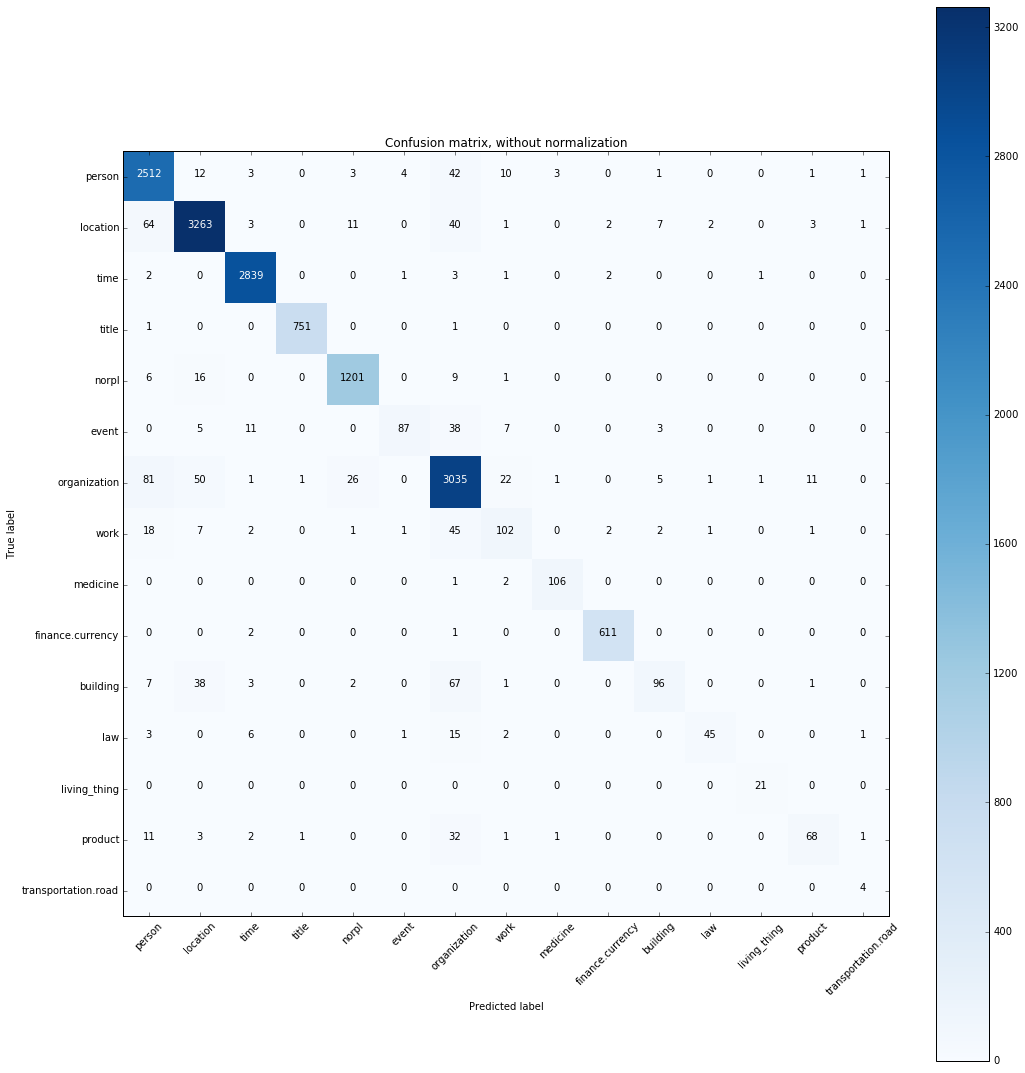

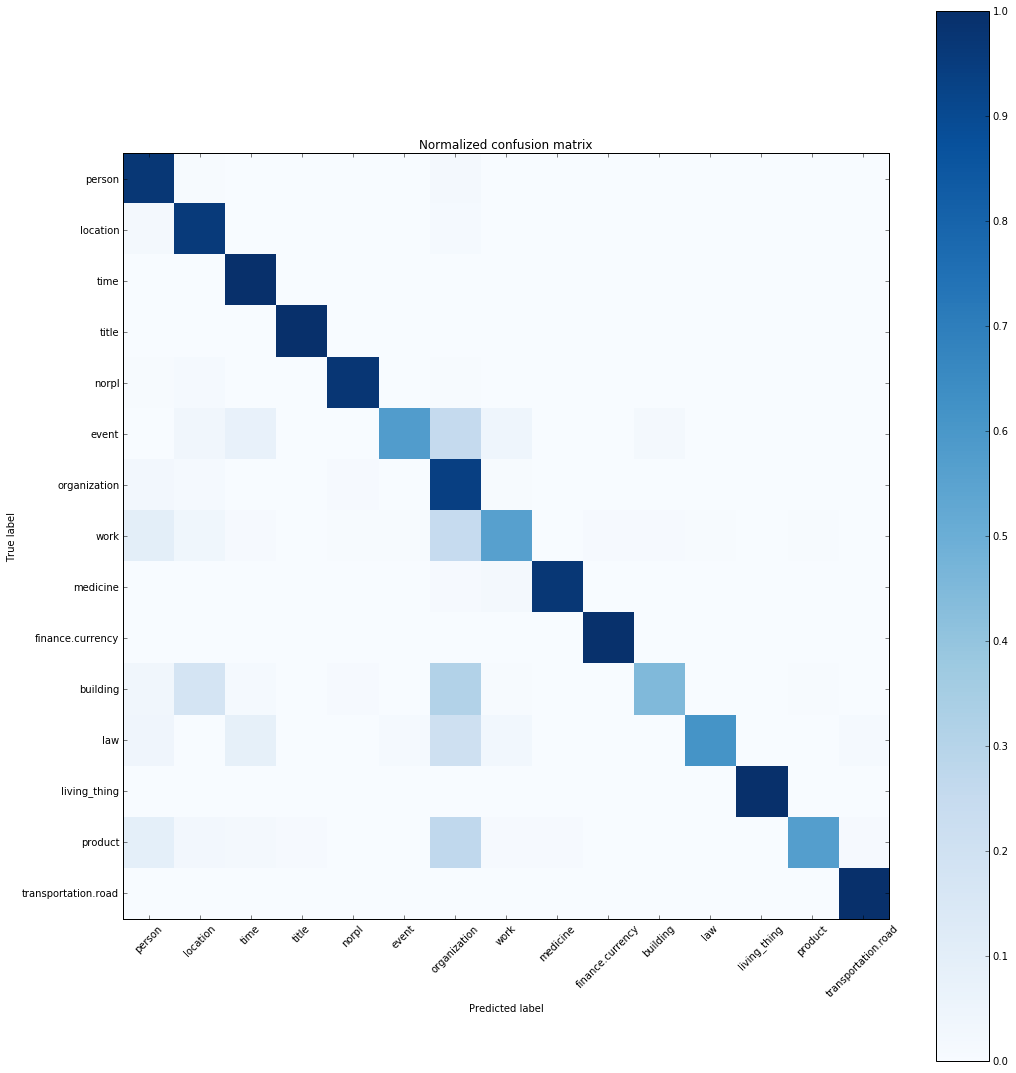

In [1017]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(ys_test, y_test_pred, classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
class_names = [index_to_type[k] for k in xrange(len(index_to_type))]
plot_confusion_matrix(cnf_matrix, classes=class_names, annotate=True,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [89]:
set(ys_figer_gold)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14}

Confusion matrix, without normalization
Normalized confusion matrix


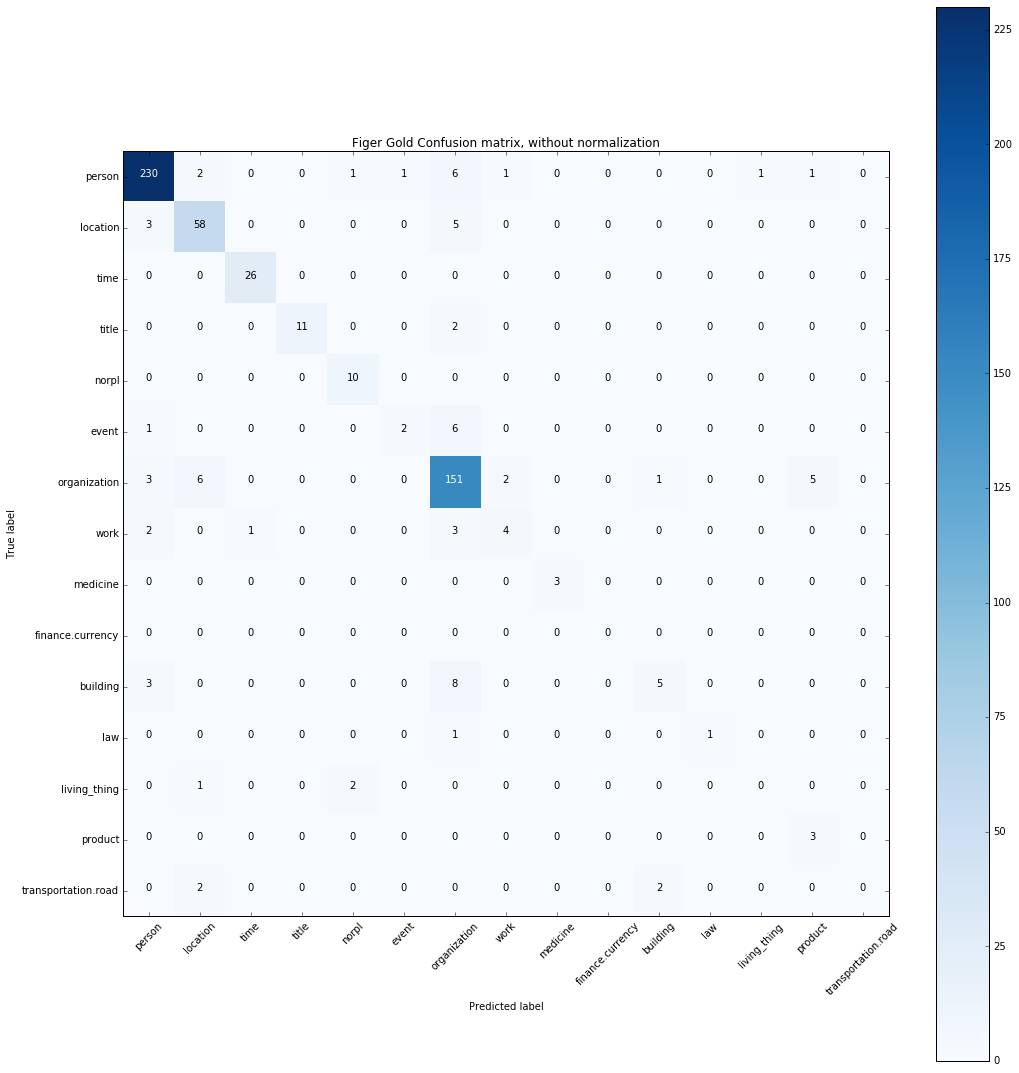

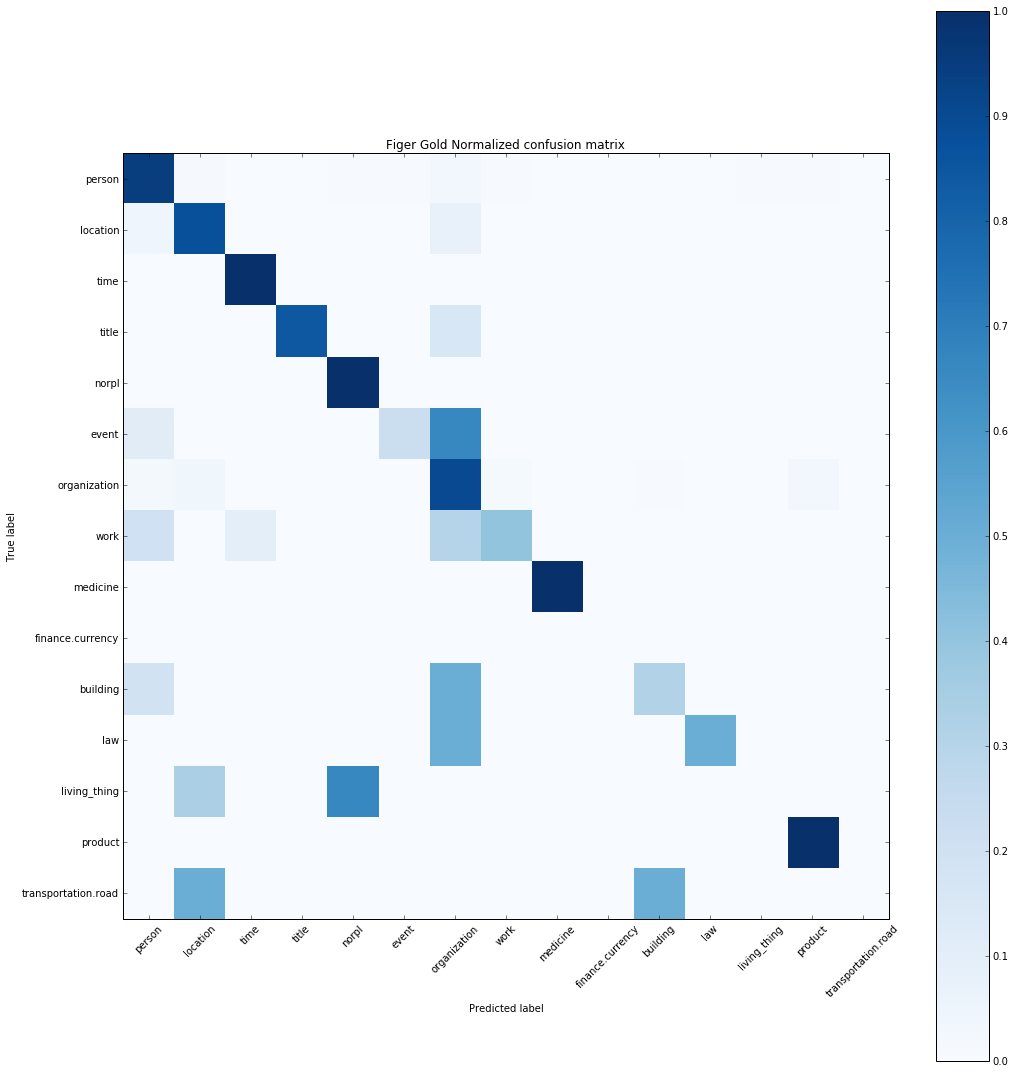

In [165]:
# Compute confusion matrix
figer_gold_cnf_matrix = confusion_matrix(ys_figer_gold, y_figer_gold_pred, classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
class_names = [index_to_type[k] for k in xrange(len(index_to_type))]
plot_confusion_matrix(figer_gold_cnf_matrix, classes=class_names, annotate=True,
                      title='Figer Gold Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(figer_gold_cnf_matrix, classes=class_names, normalize=True,
                      title='Figer Gold Normalized confusion matrix')

plt.show()

In [166]:
def interpret_prediction(lin_classifier, doc, surface, x, y_gold, index_to_feat, index_to_type, dense_feat_names, 
                         num_dense, dense_dims, 
                         num_top_sparse_feats=5):
    # assumes all dense feats are at last
    
    num_dense_dims = sum(dense_dims)
    
    # shape (num_classes, num_feats)
    scores_matrix = x.toarray().flatten() * lin_classifier.coef_
    # get best axis ≠ y
    class_scores = np.sum(scores_matrix, axis=1) + lin_classifier.intercept_
    gold_not_given = False
    if y_gold == -1:
        print "CAUTION - gold label not provided! treating the best prediciton as gold.\n\n"
        gold_not_given = True
        y_gold = np.argmax(class_scores)
    y_gold_score = class_scores[y_gold]
    top_classes = list(np.argsort(-class_scores))
    gold_position = top_classes.index(y_gold) + 1
    y_hat = top_classes[1] if gold_position == 1 else top_classes[0]
    y_hat_score = class_scores[y_hat]
    
    def print_top_sparse_feats(sparse_feat_scores):
        top_sparse_indices = np.argsort(-np.abs(sparse_feat_scores))
        def print_scores(positive):
            count = num_top_sparse_feats
            i = 0
            while count > 0:
                feat_index = top_sparse_indices[i]
                feat = index_to_feat[feat_index]
                feat_score = sparse_feat_scores[feat_index]
                if (positive and feat_score > 0) or ((not positive) and feat_score < 0):
                    count -= 1
                    print "%-30s : %.3f" % (feat, feat_score)
                elif feat_score == 0:
                    break
                i += 1
        print "top +ve sparse feats:"
        print "-"*21 + "\n"
        print_scores(True)
        print ""
        print "top -ve sparse feats:"
        print "-"*21 + "\n"
        print_scores(False)
            
    
    def print_dense(dense_feat_scores):
        print "dense feats:"
        print "-"*12 + "\n"
        for name, score in zip(dense_feat_names, dense_feat_scores):
            print "%-30s : %.3f" % (name, score)
    
    print "sentence -> %s" % doc
    print "\n"
    print "mention -> \"%s\"" % surface
    print "\n"
    
    if not gold_not_given:
        print "%s prediction" % ("✔" if y_gold_score > y_hat_score else "✘")
        print "rank of gold = %d" % gold_position
        print "\n"
    
    print "gold class, \"%s\" score = %.3f" % (index_to_type[y_gold], y_gold_score)
    print "-"*38 + "\n"
    dense_scores = scores_matrix[y_gold][-num_dense_dims:]
    dense_feat_scores = []
    cur_index = 0
    for i in xrange(num_dense):
        dense_dim = dense_dims[i]
        dense_feat_scores.append( np.sum(dense_scores[cur_index:cur_index+dense_dim]) )
        cur_index += dense_dim
    print_dense(dense_feat_scores)
    print "\n"
    print_top_sparse_feats(scores_matrix[y_gold][:-num_dense_dims])
    print "\n"

    
    print "\n"
    

    print "pred (≠ gold) class, \"%s\" score = %.3f" % (index_to_type[y_hat], y_hat_score)
    print "-"*51 + "\n"
    dense_feat_scores = np.sum(np.reshape(scores_matrix[y_hat][-num_dense_dims:], (-1, dense_dim)), axis=1)
    print_dense(dense_feat_scores)
    print "\n"
    print_top_sparse_feats(scores_matrix[y_hat][:-num_dense_dims])
    print "\n"


In [196]:
figer_gold_mistake_dict[type_lex.lexeme_to_index['living_thing']]

{1: [530], 4: [520, 521]}

In [93]:
# correct_dict[type_lex.lexeme_to_index['law']]

# Comments

sentence -> A limited liability corporation headed by Hansen recently purchased 3 acres on the east side of Occidental Avenue South between South Massachusetts and South Holgate streets . 

comment -> "streets" indicate "Occidental Avenue South", "South Massachusetts", and "South Holgate" as "transportation.road".

reannotate ontonotes "museum"'s, "hospital"'s with type facility instead of organization ("resorts" and "clinic" - more data)

In [234]:
debug_count = 0

In [210]:
kba.surface_to_type_dist["malinois"]

KeyError: 'malinois'

In [226]:
for s, index in zip(train_surfaces, ys_train):
    if "clinic" in s.lower():
        print "%-40s --> %s" % (s, index_to_type[index])

JP Investment Clinic                     --> organization
the Cleveland Clinic                     --> organization
Mayo Clinic                              --> organization
Mayo Clinic                              --> organization
Black Forest Clinic                      --> work


In [236]:
# i = figer_gold_mistake_dict[type_lex.lexeme_to_index['work']][type_lex.lexeme_to_index['person']][debug_count]
# i = figer_gold_mistake_dict[type_lex.lexeme_to_index['organization']][type_lex.lexeme_to_index['location']][debug_count]
# i = figer_gold_mistake_dict[type_lex.lexeme_to_index['living_thing']][type_lex.lexeme_to_index['norpl']][debug_count]
i = figer_gold_mistake_dict[type_lex.lexeme_to_index['work']][type_lex.lexeme_to_index['organization']][debug_count]
debug_count += 1
interpret_prediction(logreg,
                     figer_gold_docs[figer_gold_doc_indices[i]], figer_gold_surfaces[i],
                     X_figer_gold[i], ys_figer_gold[i],
                     index_to_feat, index_to_type, ["w2v-mention", "topic-score"], 2, [300, 50],
                     num_top_sparse_feats=5
                    )

sentence -> The AAAS is the largest scientific society in the world and publishes journals such as Science , and Science Translational Medicine . 


mention -> "Science Translational Medicine"


✘ prediction
rank of gold = 2


gold class, "work" score = -336.912
--------------------------------------

dense feats:
------------

w2v-mention                    : -445.160
topic-score                    : -50.649


top +ve sparse feats:
---------------------

wim=Aa                         : 93.757
wim=Science                    : 68.692
wim_lemma=science              : 68.692
wim_loc=b2-Science             : 35.540
wim_loc_lemma=b2-science       : 35.540

top -ve sparse feats:
---------------------

word_shape=Aa Aa Aa            : -50.742
wim_lemma=medicine             : -18.272
wim_loc_lemma=b0-medicine      : -18.272
wim=Medicine                   : -18.272
wim_loc=b0-Medicine            : -18.272




pred (≠ gold) class, "organization" score = 231.594
---------------------------------

In [237]:
logreg.decision_function(X_figer_gold[i])

array([[ -592.35,  -900.24, -1151.95,  -740.88,  -576.68,  -661.63,
          231.59,  -336.91,  -401.05,  -560.35,  -870.55, -1036.94,
         -539.58,  -500.19,  -504.47]])

In [122]:
doc = figer_gold_docs[figer_gold_doc_indices[i]]

In [124]:
hyp_pattern_annotator.hyp_pattern_extractor.apply_all_patterns_on_doc(doc)

{'hearst_ncompmod': [(0, [1]), (1, [2])]}

In [996]:
figer_gold_surfaces.index('San Antonio Spurs')

145

In [997]:
def print_synset_with_def(word):
    synsets = wn.synsets(word, 'n')
    for synset in synsets:
        print("%s - %d - %s" % (synset, synset.offset(), synset.definition()))

In [800]:
print_view(figer_docs[figer_doc_indices[i]], NSDView.NSD_VIEW_NAME)

streets ({u'4335209_n': 0.38568958256649305, u'14516256_n': 0.28059687123254651, u'14485811_n': 0.22626387059362552, u'8225426_n': 0.31594839556319565, u'4334599_n': 0.40805306925348578}) 
Avenue ({u'941604_n': 0.22768611402742372, u'2763472_n': 0.40439907782951973}) 
South ({u'9050730_n': 0.5370128722458396, u'9050244_n': 0.43209950244714318, u'8561583_n': 0.4955123940731509, u'13835899_n': 0.2846012885688457, u'13833375_n': 0.19321643613815637}) 
side ({u'8408709_n': 0.32322112892543953, u'6783265_n': 0.29312259349194369, u'5551318_n': 0.31845582048284549, u'8102282_n': 0.24261407127184773, u'7442569_n': 0.24891334789603778, u'8649345_n': 0.3649049217773645, u'7655626_n': 0.2671162929180827, u'5852553_n': 0.17060880169401538, u'9437454_n': 0.20730169931987882, u'4213626_n': 0.20898956896527321, u'8510666_n': 0.29095535729980537, u'8649167_n': 0.33405396788111102}) 
liability ({u'14490319_n': 0.29603206398969711, u'5161436_n': 0.2936899765200025, u'14530403_n': 0.28255214753817914}) 


In [797]:
print_view(figer_docs[figer_doc_indices[i]], FineTypeView.FINE_TYPE_VIEW_NAME)

South Holgate ({'transportation.road': 1.0, 'location': 1.0, 'language': 1.0, 'person': 1.0}) 
Occidental Avenue South ({'product': 1.0, 'language': 1.0, 'body_part': 1.0, 'person': 1.0, 'location': 1.0, 'transportation.road': 1.0, 'organization': 1.0, 'event': 1.0, 'geography': 1.0}) 
Hansen ({'body_part': 1.0, 'organization.company': 1.0, 'organization': 1.0}) 
3 acres ({'product': 1.0, 'body_part': 1.0, 'location': 1.0, 'organization': 1.0, 'event': 1.0, 'geography': 1.0}) 
South Massachusetts ({'transportation.road': 1.0, 'location': 1.0, 'event': 1.0, 'language': 1.0, 'person': 1.0}) 


In [173]:
# s = " Avenue"
# for k in kba.surface_to_type_dist:
#     if s in k:
#         print k
#         print kba.surface_to_type_dist[k]

In [804]:
print_synset_with_def('Occidental')

Synset('occidental.n.01') - 10369845 - a native inhabitant of the Occident
Synset('occidental.n.02') - 6897474 - an artificial language


In [175]:
# with figer docs
i = 295 # house bill 2221
i = 126 # sonics
i = 146 # San Antonio Spurs
i = 147 # Orlando Magic
i = 152 # New Jersey Nets
# with figer gold docs
i = 145 # San Antonio Spurs
interpret_prediction(logreg,
                     figer_gold_docs[figer_gold_doc_indices[i]], figer_gold_surfaces[i],
                     X_figer_gold[i], ys_figer_gold[i],
                     index_to_feat, index_to_type, ["w2v-mention", "topic-score"], 2, [300, 50],
                     num_top_sparse_feats=5
                    )

sentence -> Hirsh , managing partner of Stafford Sports in New Jersey , has advised the San Antonio Spurs through construction of their new arena , the AT&T Center . 


mention -> "San Antonio Spurs"


✘ prediction
rank of gold = 2


gold class, "organization" score = -15.848
--------------------------------------

dense feats:
------------

w2v-mention                    : -252.066
topic-score                    : 112.616


top +ve sparse feats:
---------------------

kbbias=organization.sports_team : 146.492
wim=Aa                         : 29.381
dep_feature=<- advise          : 22.970
wim=San                        : 11.073
wim_lemma=san                  : 11.073

top -ve sparse feats:
---------------------

dep_feature=-> the             : -36.483
word_shape=Aa Aa Aa            : -24.402
wim_loc=f0-San                 : -12.479
wim_loc_lemma=f0-san           : -12.479
dep_feature=-det-> the         : -1.867




pred (≠ gold) class, "location" score = 104.671
----------------------

In [197]:
index_to_type

{0: 'person',
 1: 'location',
 2: 'time',
 3: 'title',
 4: 'norpl',
 5: 'event',
 6: 'organization',
 7: 'work',
 8: 'medicine',
 9: 'finance.currency',
 10: 'building',
 11: 'law',
 12: 'living_thing',
 13: 'product',
 14: 'transportation.road'}